In this notebook, we may test some of the algorithm's properties on a real dataset (GBSG)

### 0- Library importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


from src.algorithms import * 
from src.utils import * 
from src.metrics_FAMD import *

import warnings
warnings.filterwarnings('ignore')

### 1- Initialization

#### 1.1 - Load dataset

In [2]:
gbsg = pd.read_csv("../GBSG2")

#### 1.2 - Parameter definition 

In [3]:
np.random.seed(21032024) # Set random seed to create reproductible results


# Shape of dataset before encoding dummy variables 
I, J = gbsg.shape

# Categorical Variables :
idx_k2_gbsg = pd.Index(["meno","hormon","status","grade"])

# Continuous Variables
idx_k1_gbsg = gbsg.columns.difference(idx_k2_gbsg)

#Define number of iterations 
n_it = 1000
n_components = 5

#### 1.3- Inject missing values and encode dummy variables

In [4]:
# Inject missing values into the gbsg dataframe for different probabilities
proba_non_missing = [0.7, 0.8, 0.9]

# Create a dictionnary 
dict_dfs = {}
for p in proba_non_missing: 
    # Create missingness
    gbsg_missing = create_missingness(gbsg, p)

    # Encode dummy variables: 
    gbsg_missing_dummy, idx_j_gbsg, nb_values_per_cat_gbsg = encode_dummy_variables(gbsg_missing, idx_k2_gbsg) # dataframe with missing values 
    gbsg_dummy = encode_dummy_variables(gbsg, idx_k2_gbsg)[0] # complete dataset 

    # Add variables to dictionnary
    dict_dfs.update({p:[idx_k1_gbsg, idx_j_gbsg, gbsg_missing_dummy, gbsg_dummy, nb_values_per_cat_gbsg]})
    print("Proba non missing: "f'{p}', "\nMissingness rate: ",gbsg_missing.isna().sum().sum()/(gbsg_missing.shape[0]*gbsg_missing.shape[1]), "\n")

Proba non missing: 0.7 
Missingness rate:  0.29525576464351977 

Proba non missing: 0.8 
Missingness rate:  0.20063609859528228 

Proba non missing: 0.9 
Missingness rate:  0.10349854227405247 



### 2- Run algorithms 

#### a - Test for several missingness probabilities

#### a.1- Iterative FAMD 

In [5]:
# Create lists where we will save progressively the scores
fc_rate = [] # Falsely classified rate
nmrse = [] # NRMSE

# For each probability
for p,values in dict_dfs.items(): 
    
    k1, k_j, df_gbsg, df_true, nb_val_per_car = values
    C0_missing, Categ_missing = df_gbsg.isna()[k1].to_numpy(), df_gbsg.isna()[k_j].to_numpy()  
    ifamd_gbsg = IterativeFAMDImputer(n_components=n_components, data=df_gbsg, k1=k1, k2=k_j, nb_values_per_cat = nb_val_per_car)

    #Computation of iterative FAMD
    ifamd_gbsg.impute(n_it)
    df = ifamd_gbsg.df

    #Compute metrics 
    # For categorical variables 
    res = (df[ifamd_gbsg.k2].copy()>=0.5).astype(int)
    fc_rate.append(metric_fc(res[Categ_missing], df_true[k_j][Categ_missing]))

    # For continuous variables: 
    nmrse.append(compute_nrmse_weighted(df[k1][C0_missing].astype(int), df_true[k1][C0_missing]))

fc_rate = np.array(fc_rate)
nmrse = np.array(nmrse)

Converged in 51
Converged in 49
Converged in 47


#### a.2- Alternative techniques

In [6]:
# Create lists where we will save progressively the scores
# Mean imputation 
fc_rate_mean = []
nmrse_mean = []
# Random forest 
fc_rate_rf = []
nmrse_rf = []
# Random imputation
fc_rate_ri = []
nmrse_ri = []

for p,values in dict_dfs.items(): 

    k1, k_j, df_gbsg, df_true, nb_val_per_car = values
    C0_missing, Categ_missing = df_gbsg.isna()[k1].to_numpy(), df_gbsg.isna()[k_j].to_numpy() 

    # Simple imputation with mean 
    simple_imputation =  pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_gbsg), columns=df_gbsg.columns)

    # Imputation with a Random Forest regressor
    enable_iterative_imputer
    rf_imputer = pd.DataFrame(IterativeImputer(estimator=RandomForestRegressor()).fit_transform(df_gbsg), columns=df_gbsg.columns)

    # Random imputation 
    ri_imputer = random_imputation(df_gbsg).astype(int)

    # Compute metrics 
    # For categorical variables (FCP)
    res_si = (simple_imputation[ifamd_gbsg.k2].copy()>=0.5).astype(int)

    fc_rate_mean.append(metric_fc(res_si[Categ_missing], df_true[k_j][Categ_missing]))
    fc_rate_rf.append(metric_fc(rf_imputer[k_j][Categ_missing], df_true[k_j][Categ_missing]))
    fc_rate_ri.append(metric_fc(ri_imputer[k_j][Categ_missing], df_true[k_j][Categ_missing]))

    # For continuous variables (NRMSE)
    nmrse_mean.append(compute_nrmse_weighted(simple_imputation[k1][C0_missing].astype(int), df_true[k1][C0_missing]))
    nmrse_rf.append(compute_nrmse_weighted(rf_imputer[k1][C0_missing].astype(int), df_true[k1][C0_missing]))
    nmrse_ri.append(compute_nrmse_weighted(ri_imputer[k1][C0_missing].astype(int), df_true[k1][C0_missing]))

#### a.3 - Figures

##### Categorical variables

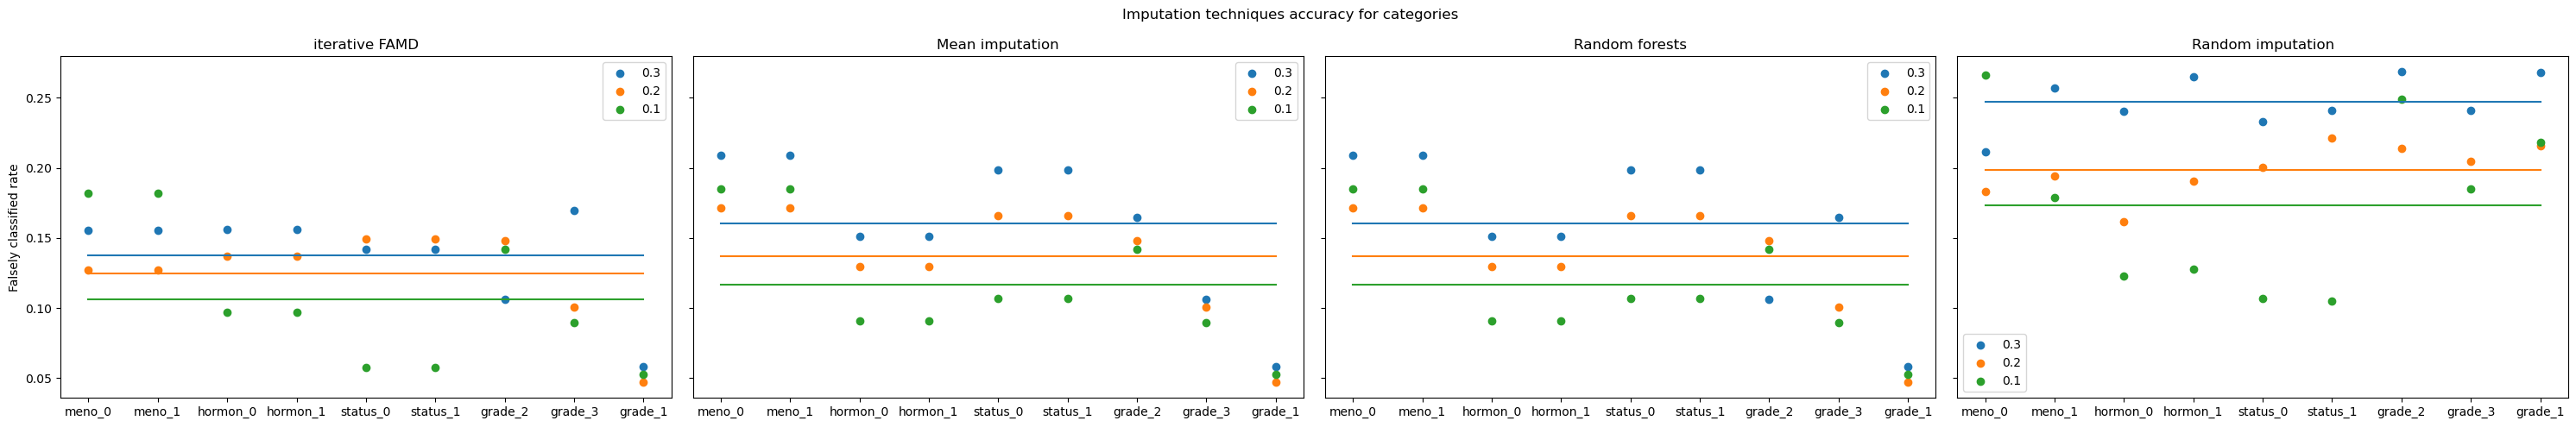

In [18]:
fig, ax = plt.subplots(figsize=(30,5),ncols=4, sharey=True)
fig.suptitle('Imputation techniques accuracy for categories')

proba_missing_str = ['0.3', '0.2', '0.1']

for i, vect in enumerate(fc_rate): 
    vect_mean = fc_rate_mean[i]
    vect_rf = fc_rate_rf[i]
    vect_ri = fc_rate_ri[i]
    ax[0].scatter(k_j.to_numpy(), vect, label=proba_missing_str[i])
    ax[0].plot(k_j.to_numpy(),np.ones_like(k_j.to_numpy())*vect.mean())
    ax[0].set_ylabel("Falsely classified rate")
    ax[0].set_title("iterative FAMD")
    ax[0].legend()

    ax[1].scatter(k_j.to_numpy(), vect_mean, label=proba_missing_str[i])
    ax[1].plot(k_j.to_numpy(),np.ones_like(k_j.to_numpy())*vect_mean.mean())
    ax[1].set_title("Mean imputation")
    ax[1].legend()

    ax[3].scatter(k_j.to_numpy(), vect_ri, label=proba_missing_str[i])
    ax[3].plot(k_j.to_numpy(),np.ones_like(k_j.to_numpy())*vect_ri.mean())
    ax[3].set_title("Random imputation")
    ax[3].legend()

    ax[2].scatter(k_j.to_numpy(), vect_rf, label=proba_missing_str[i])
    ax[2].plot(k_j.to_numpy(),np.ones_like(k_j.to_numpy())*vect_rf.mean())
    ax[2].set_title("Random forests")
    ax[2].legend()

fig.tight_layout()
fig.savefig('images/gbsg2/PFC_categories.png')
plt.show()

**Observations on categorical variables**

- As rate of missing data increases: imputation error increases as well
- iterative FAMD is far better than Random Forest imputation and proportion imputation

##### Continuous variables 

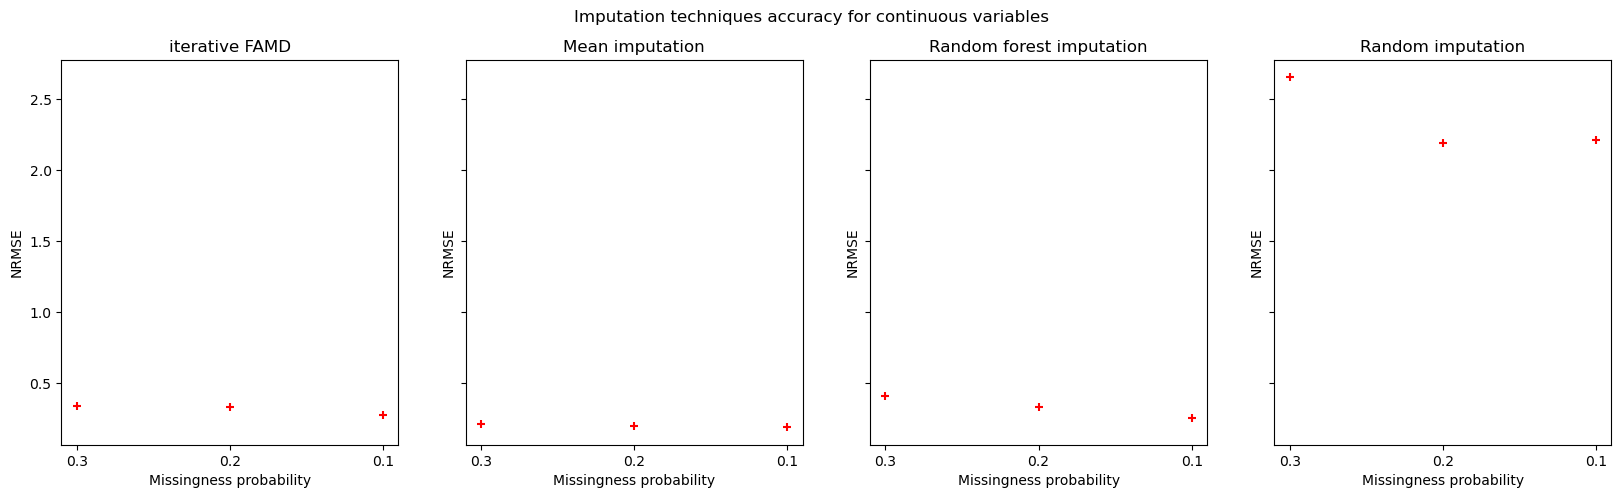

In [13]:
fig, ax = plt.subplots(figsize=(20,5),ncols=4, sharey=True,sharex=True)
fig.suptitle('Imputation techniques accuracy for continuous variables')

ax[0].scatter(proba_missing_str, nmrse, color='r', marker='+')
ax[0].set_ylabel("NRMSE")
ax[0].set_xlabel("Missingness probability")
ax[0].set_title("iterative FAMD")

ax[1].scatter(proba_missing_str, nmrse_mean, color='r', marker='+')
ax[1].set_ylabel("NRMSE")
ax[1].set_xlabel("Missingness probability")
ax[1].set_title("Mean imputation")

ax[2].scatter(proba_missing_str, nmrse_rf, color='r', marker='+')
ax[2].set_ylabel("NRMSE")
ax[2].set_xlabel("Missingness probability")
ax[2].set_title("Random forest imputation")

ax[3].scatter(proba_missing_str, nmrse_ri, color='r', marker='+')
ax[3].set_ylabel("NRMSE")
ax[3].set_xlabel("Missingness probability")
ax[3].set_title("Random imputation")

fig.savefig('images/gbsg2/NRMSE_continuous.png')
plt.show()

**Observations on continuous variables**

- As rate of missing data increases: proportion of missclassification increases as well
- Far better results than random imputation

#### b - Choice of number of dimensions 

##### b.1 - Iterative FAMD

In [14]:
# Different number of components for reconstruction 
n_components = [2,4,5,6,7, 10]

# Fixed missingness probability
proba_non_missing = 0.8


fc_rate_nc = []
nmrse_nc = []

for n in n_components: 
    k1, k_j, df_gbsg, df_true, nb_val_per_car = dict_dfs[proba_non_missing]
    C0_missing, Categ_missing = df_gbsg.isna()[k1].to_numpy(), df_gbsg.isna()[k_j].to_numpy()  
    
    #Computation of iterative FAMD
    ifamd_gbsg = IterativeFAMDImputer(n_components=n, data=df_gbsg, k1=k1, k2=k_j, nb_values_per_cat = nb_val_per_car)
    ifamd_gbsg.impute(n_it)
    df = ifamd_gbsg.df

    #Compute metrics 
    # For categorical variables 
    res = (df[ifamd_gbsg.k2].copy()>=0.5).astype(int)
    fc_rate_nc.append(metric_fc(res[Categ_missing], df_true[k_j][Categ_missing]))

    # For continuous variables: 
    nmrse_nc.append(compute_nrmse_weighted(df[k1][C0_missing].astype(int), df_true[k1][C0_missing]))

fc_rate_nc  =np.array(fc_rate_nc)
nmrse_nc = np.array(nmrse_nc)

Converged in 70
Converged in 56
Converged in 49
Converged in 43
Converged in 36
Converged in 15


#### Figure: iterative FAMD for different number of components 

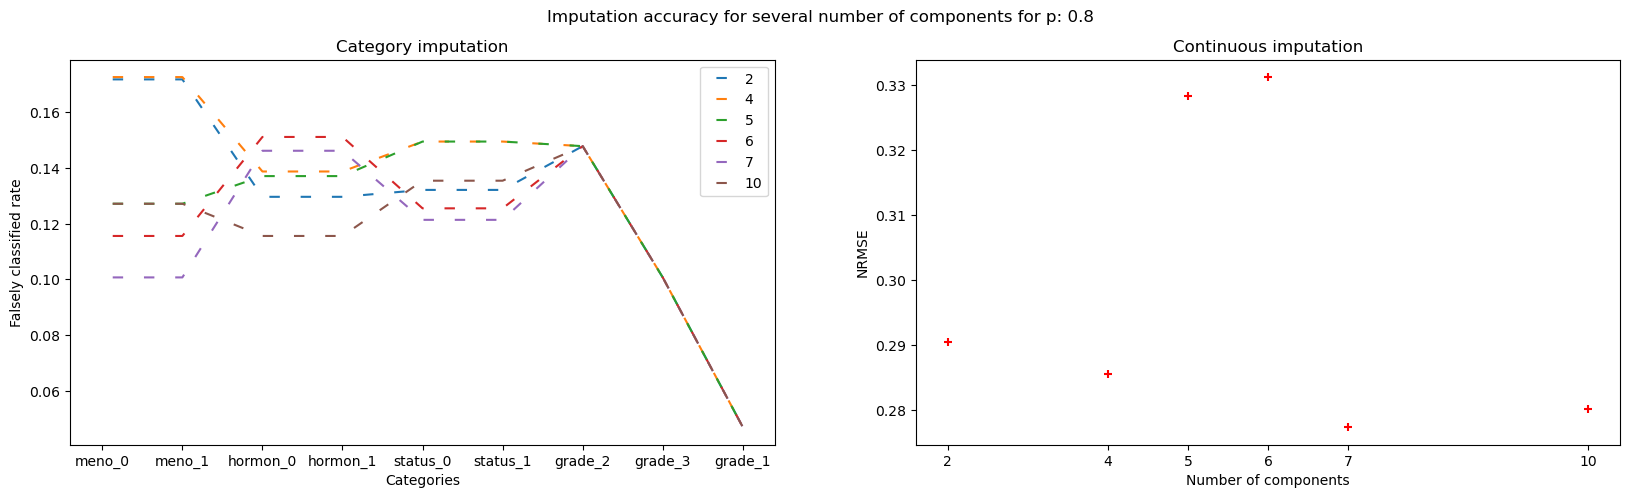

In [19]:
fig, ax = plt.subplots(figsize=(20,5),ncols=2)
fig.suptitle('Imputation accuracy for several number of components for p: '+f'{proba_non_missing}')

for i in range(len(n_components)): 
    ax[0].plot(k_j.to_numpy(), fc_rate_nc[i], label=n_components[i], linestyle= (10, (5, 10)) )
    ax[0].set_ylabel("Falsely classified rate")
    ax[0].set_title("Category imputation")
    ax[0].set_xlabel("Categories")
ax[0].legend()

ax[1].scatter(n_components, nmrse_nc, color='r', marker='+')
ax[1].set_xticks(n_components, ['2','4','5','6','7','10'])
ax[1].set_ylabel("NRMSE")
ax[1].set_title("Continuous imputation")
ax[1].set_xlabel("Number of components")
fig.savefig('images/gbsg2/number_components.png')
plt.show()

#### Figure: comparison for several techniques

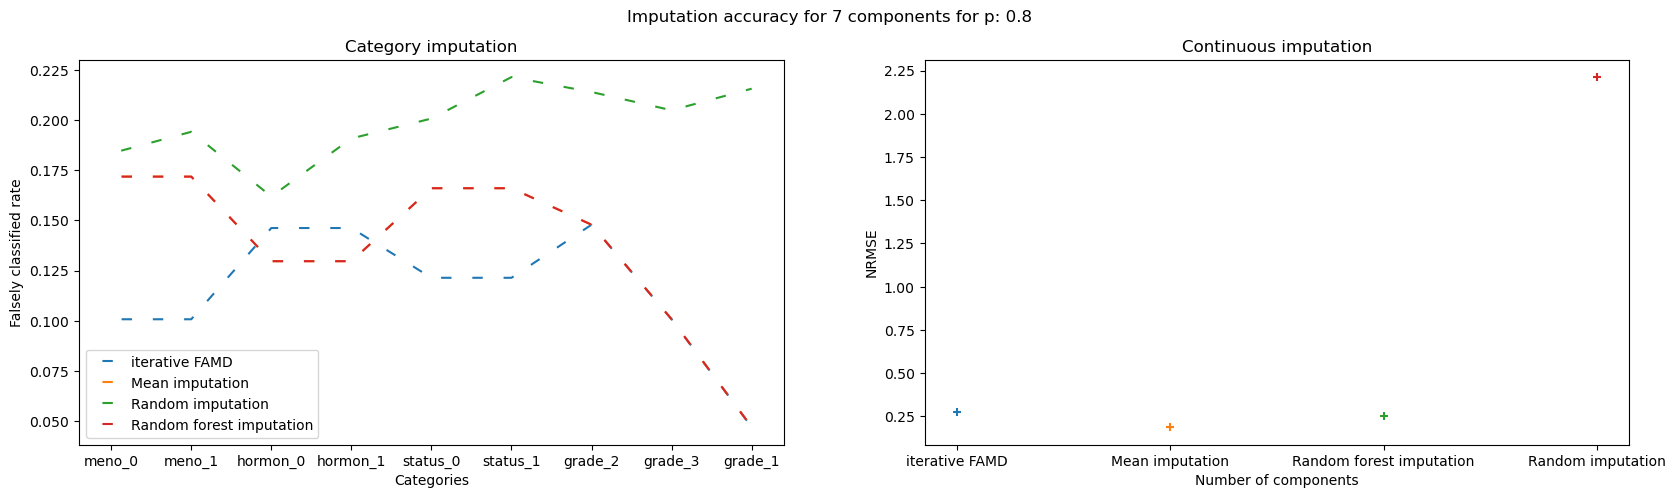

In [17]:
fig, ax = plt.subplots(figsize=(20,5),ncols=2)
fig.suptitle(f"Imputation accuracy for {n_components[4]} components for p: {proba_non_missing}")

ax[0].plot(k_j.to_numpy(), fc_rate_nc[4], label='iterative FAMD', linestyle= (10, (5, 10)) )
ax[0].plot(k_j.to_numpy(), fc_rate_mean[1], label='Mean imputation', linestyle= (10, (5, 10)) )
ax[0].plot(k_j.to_numpy(), fc_rate_ri[1], label='Random imputation', linestyle= (10, (5, 10)) )
ax[0].plot(k_j.to_numpy(), fc_rate_rf[1], label='Random forest imputation', linestyle= (10, (5, 10)) )
ax[0].set_ylabel("Falsely classified rate")
ax[0].set_title("Category imputation")
ax[0].set_xlabel("Categories")
ax[0].legend()

ax[1].scatter(np.linspace(0,4,4),[nmrse_nc[4],np.nan,np.nan,np.nan], marker='+')
ax[1].scatter(np.linspace(0,4,4),[np.nan,nmrse_mean[2],np.nan,np.nan], marker='+')
ax[1].scatter(np.linspace(0,4,4),[np.nan,np.nan,nmrse_rf[2], np.nan], marker='+')
ax[1].scatter(np.linspace(0,4,4),[np.nan,np.nan, np.nan,nmrse_ri[2]], marker='+')
ax[1].set_xticks(np.linspace(0,4,4), ['iterative FAMD','Mean imputation', 'Random forest imputation','Random imputation'])
ax[1].set_ylabel("NRMSE")
ax[1].set_title("Continuous imputation")
ax[1].set_xlabel("Number of components")
fig.savefig('images/gbsg2/nb_components_comparison.png')
plt.show()